# Plotting Examples

There are a variety of methods that can be used to visualize a network.

In [1]:
import pynucastro as pyna

## Rotated View

Let's build a quick network that represents He, C, and O burning

In [2]:
library = pyna.Library("20180319default2")

In [3]:
sub = library.linking_nuclei(["p", "n", "he4", "c12", "n13", "n14", "o16",
                              "ne20", "ne21", "na23", "mg23", "mg24", "al27", "si27", "si28"])
rc = pyna.RateCollection(libraries=sub)

The standard network plot of this is:

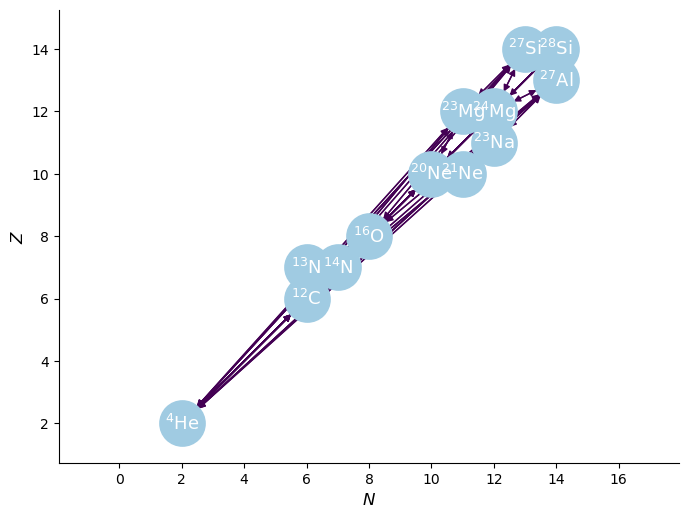

In [4]:
rc.plot()

Since everything lies close to the diagonal, it is hard to see the structure.  We can instead look at a rotated view of the network.

While we're at it, we'll also color the rates by reaction rate strength

In [5]:
comp = pyna.Composition(rc.get_nuclei())
comp.set_solar_like()

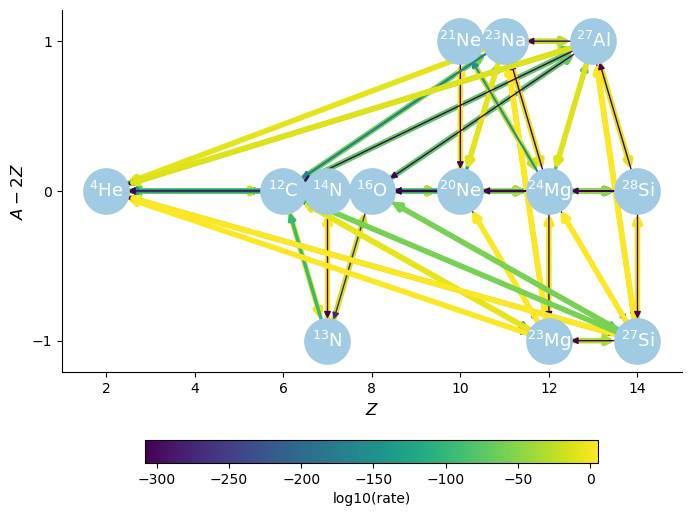

In [6]:
rc.plot(rho=1e4, T=1e8, comp=comp, rotated=True)

This looks a bit crowded, since it is showing all of the links to ${}^4\mathrm{He}$ from reactions of the form $A(x, \alpha)B$.  We can hide those links with ``hide_xalpha=True``

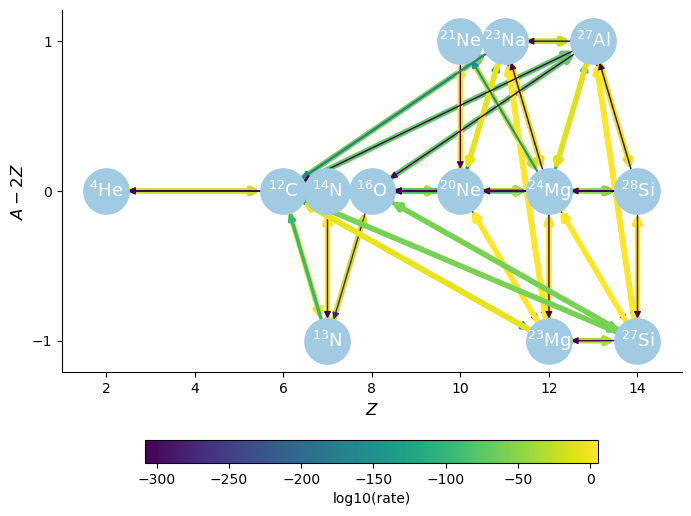

In [7]:
rc.plot(rho=1e4, T=1e8, comp=comp, rotated=True, hide_xalpha=True)

We can also use a rate filter to show only certain links.  For example, to show only links involving proton capture, we can do:

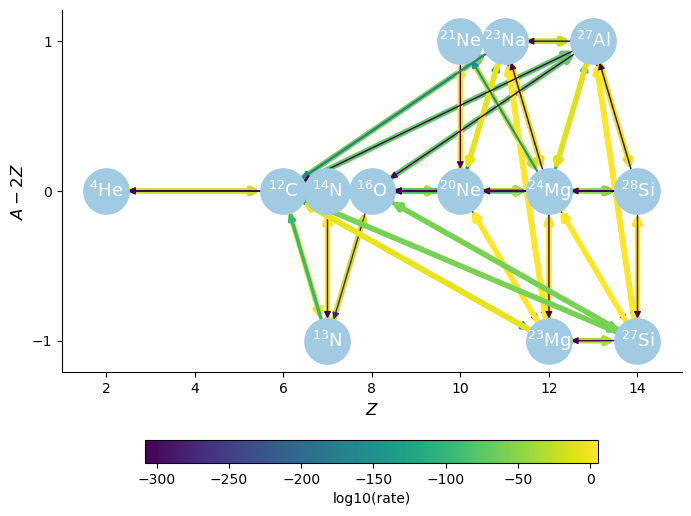

In [8]:
rc.plot(rho=1e4, T=1e8, comp=comp, rotated=True, hide_xalpha=True)

## Plot nuclides on a grid

Nuclides in a network may also be visualized as cells on a grid of Z vs. N, colored by some quantity. This can be more interpretable for large networks. Calling `gridplot` without any arguments will just plot the grid - to see anything interesting we need to supply some conditions. Here is a plot of nuclide mass fraction on a log scale, with a 36 square inch figure:

In [9]:
files = ["c12-pg-n13-ls09", 
         "c13-pg-n14-nacr",
         "n13--c13-wc12",
         "n13-pg-o14-lg06",
         "n14-pg-o15-im05",
         "n15-pa-c12-nacr",
         "o14--n14-wc12",
         "o15--n15-wc12"]
rc = pyna.RateCollection(files)

In [10]:
comp = pyna.Composition(rc.get_nuclei())
comp.set_solar_like()

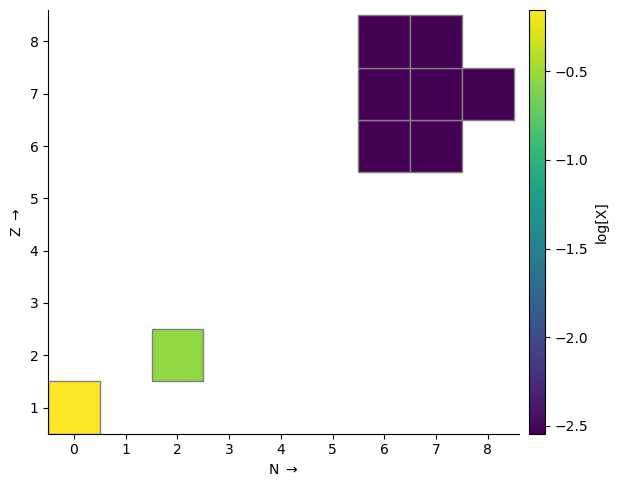

In [11]:
rc.gridplot(comp=comp, color_field="X", scale="log", area=36)

The plot is configurable through a large number of keyword arguments. Here we want to look at the rates at which nuclides are being created or destroyed, so we color by $\dot{Y}$, the rate of change of molar abundance. Density and temperature need to be supplied to evaluate the rates. A full list of valid keyword arguments can be found in the API documentation.

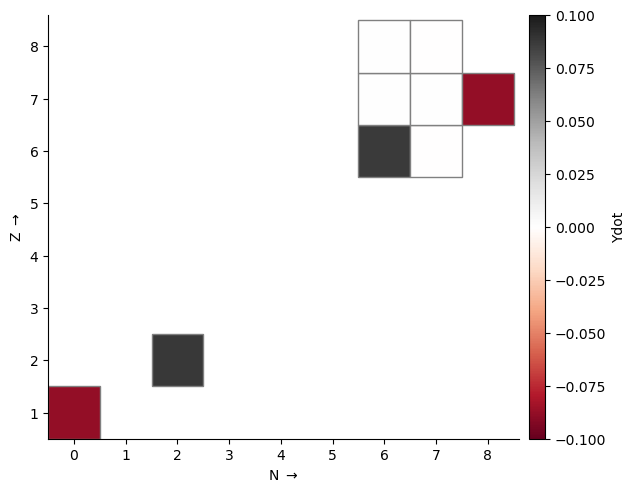

In [12]:
rc.gridplot(comp=comp, rho=1e4, T=1e8, color_field="ydot", area=36,
        cmap="RdGy", cbar_bounds=(-0.1, 0.1))

Unlike the network plot, this won't omit hydrogen and helium by default. To just look at the heavier nuclides, we can define a function to filter by proton number.  Here we also plot
*activity*, which is the sum of all rates contributions to Ydot ignoring the sign.

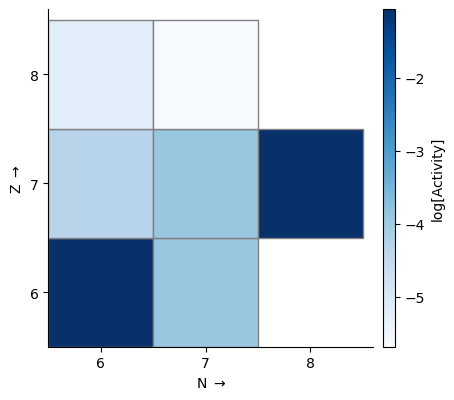

In [13]:
ff = lambda nuc: nuc.Z > 2
rc.gridplot(comp=comp, rho=1e4, T=1e8, color_field="activity", scale="log",
            filter_function=ff, area=20, cmap="Blues")

# Network Chart

A network chart shows how each rate affects each nucleus

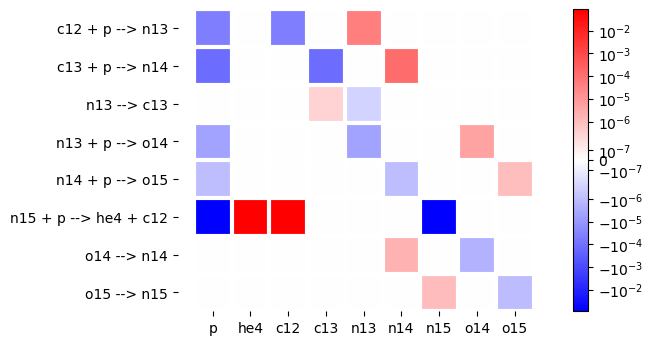

In [15]:
rc.plot_network_chart(rho=1.e4, T=1.e8, comp=comp)